In [1]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

In [21]:
simulation = Sphere(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape()

volume fraction is 0.00000, radius is 0.11, center at (0.5,4.3,-0.9) 
volume fraction is 0.00006, radius is 0.11, center at (0.7,-3.7,-4.7) 
volume fraction is 0.00007, radius is 0.11, center at (4.4,-3.5,4.0) 
volume fraction is 0.00007, radius is 0.11, center at (3.9,-3.0,4.8) 
volume fraction is 0.00007, radius is 0.11, center at (-1.9,4.8,-4.1) 
volume fraction is 0.00011, radius is 0.11, center at (-1.0,2.6,3.9) 
volume fraction is 0.00012, radius is 0.11, center at (2.4,2.3,0.4) 
volume fraction is 0.00013, radius is 0.11, center at (0.3,3.2,-3.7) 
volume fraction is 0.00023, radius is 0.11, center at (-3.4,3.7,0.6) 
volume fraction is 0.00029, radius is 0.11, center at (-2.7,-1.0,-1.1) 
volume fraction is 0.00030, radius is 0.11, center at (-4.2,-1.0,-2.8) 
volume fraction is 0.00036, radius is 0.11, center at (-2.1,-2.1,4.4) 
volume fraction is 0.00037, radius is 0.11, center at (-1.7,-4.4,0.4) 
volume fraction is 0.00038, radius is 0.11, center at (-3.2,1.8,-2.0) 
volume fract

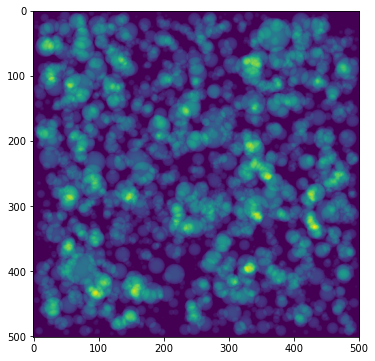

In [22]:
plt.figure(figsize=(6,6))
plt.imshow(simulation.density.sum(axis=0))

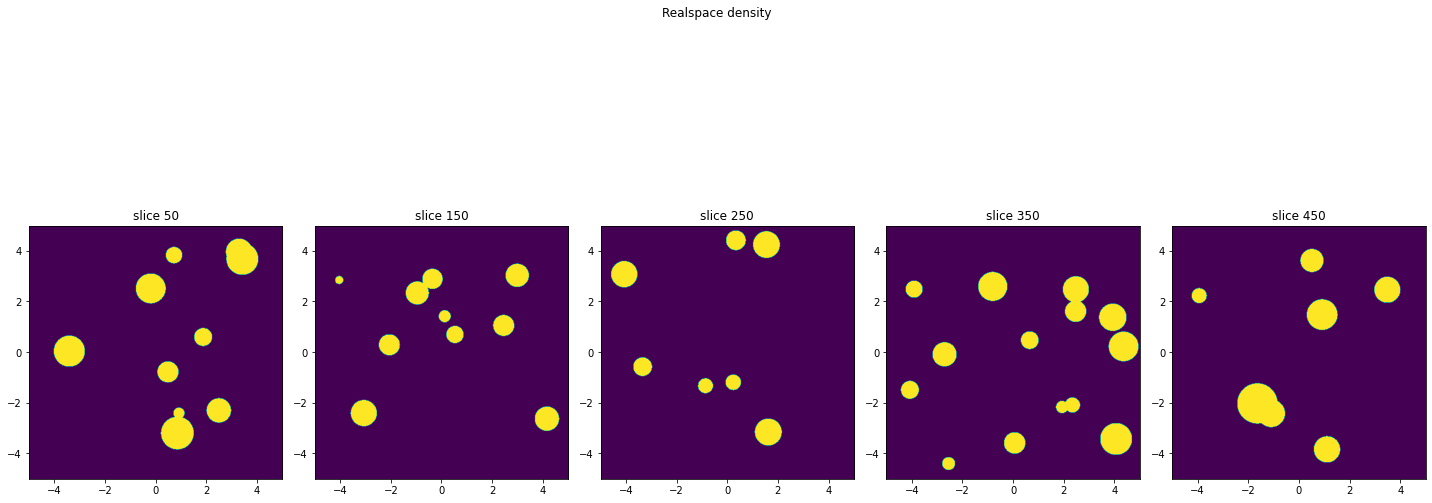

In [4]:
plot_slices(simulation.density, simulation.grid)

In [4]:
#plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [23]:
simulation.pin_memory()

In [24]:
simulation.calculate_custom_FTI_3D_slice(device = 'cuda')

In [32]:
temp = np.abs(np.sinc(simulation._q2y*simulation.grid_space/2/np.pi)*np.sinc(simulation._q2z*simulation.grid_space/2/np.pi))**2

In [33]:
t2 = np.where(temp<0.9, 0, temp)

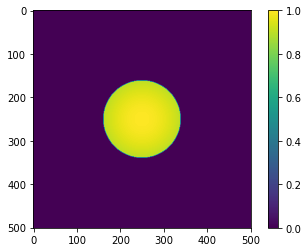

In [34]:
im = plt.imshow(t2)
plt.colorbar(im)

In [13]:
#simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cuda')

the maximal difference between the implementation of the FTI is 0.010353933946749673


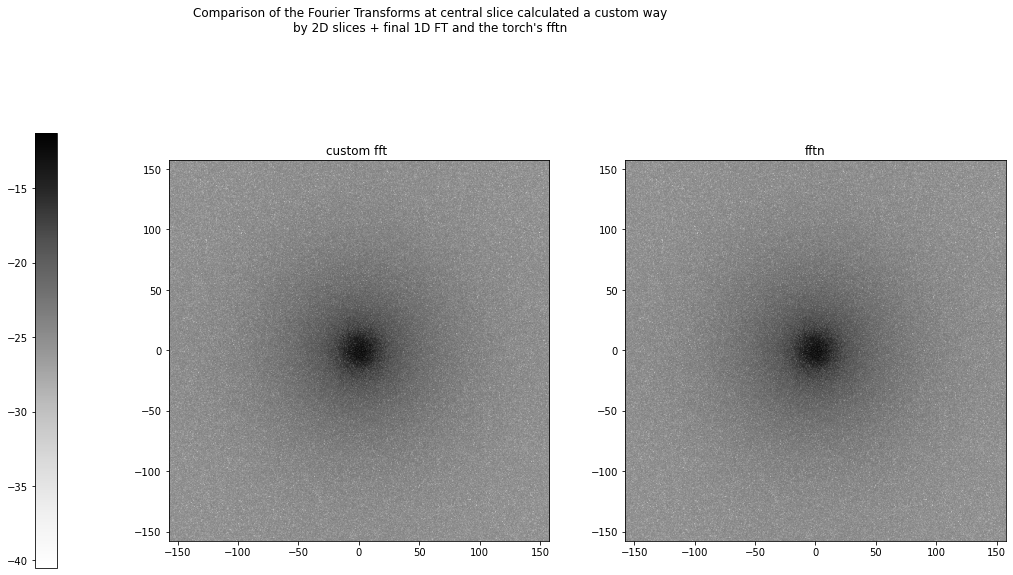

In [14]:
plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

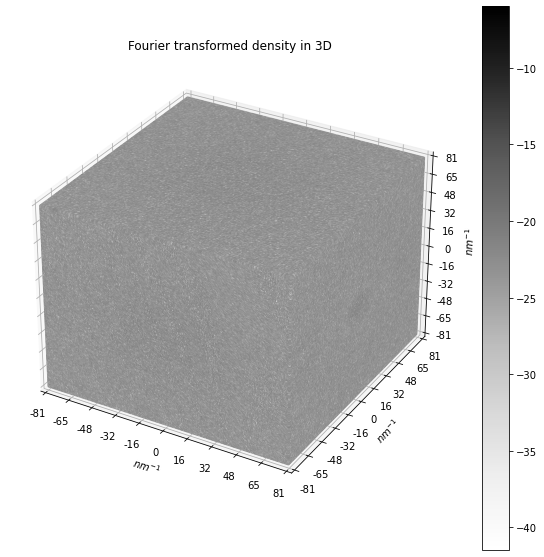

In [19]:
import torch
#plot_3D_structure(torch.from_numpy(simulation.FTI), simulation.qx, realspace= False)#, path = 'figures/FFT_spheres_example.png')

In [15]:
simulation.sinc

AttributeError: 'Sphere' object has no attribute 'sinc'

torch.Size([196293]) (196293,)


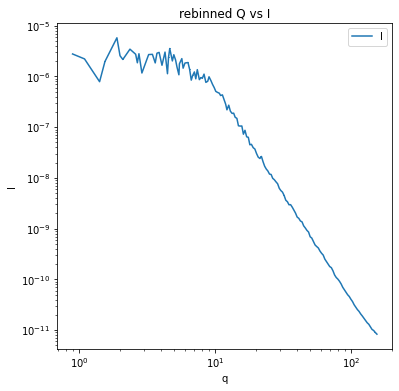

In [16]:
simulation.reBin(200, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [17]:
simulation.init_sas_model()

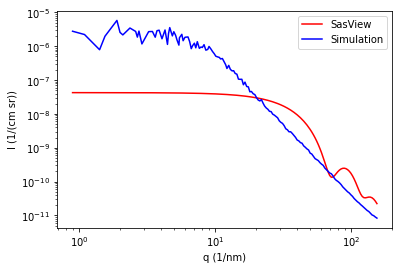

In [18]:
simulation.init_sas_model()
simulation.update_scaling(3.8722e-1)
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

In [19]:
simulation.save_data(directory='dat_files')
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.rMean))

the sphere file with radius 0.062  is saved


In [13]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

simulation = Cylinder(size = 10, nPoints = 251, volFrac = 0.05)
simulation.place_shape(single = False)
print(simulation.theta, simulation.phi,simulation.grid_space)

rMean -0.17413535908533445
rMean -0.5196263346953207
rMean 0.3133705186201697
A: (2.65,-0.88), C: (3.16,-0.88)
[-3.51592360e-17 -8.84226859e-01]
Ellipse equation: (x-(+2.90))^2/0.26^2 +(y -(-0.63))^2/0.27^2<1, line equation: y > -0.00x-0.88
A: (3.16,-2.35), C: (2.65,-2.35) 0 0.08280164003372192
Ellipse equation: (x-(+2.90))^2/0.26^2 +(y -(-2.54))^2/0.27^2<1, line equation: y < -0.00x-2.35
A: (2.65,-0.55), C: (3.16,-0.55)
[-3.51592360e-17 -5.48469126e-01]
Ellipse equation: (x-(+2.90))^2/0.26^2 +(y -(-0.68))^2/0.27^2<1, line equation: y > -0.00x-0.55
A: (3.16,-2.52), C: (2.65,-2.52) 0 0.2958442270755768
Ellipse equation: (x-(+2.90))^2/0.26^2 +(y -(-2.49))^2/0.27^2<1, line equation: y < -0.00x-2.52
A: (2.65,-0.66), C: (3.16,-0.66)
[-3.51592360e-17 -6.60387874e-01]
Ellipse equation: (x-(+2.90))^2/0.26^2 +(y -(-0.66))^2/0.27^2<1, line equation: y > -0.00x-0.66
A: (3.16,-2.41), C: (2.65,-2.41) 0 0.16962940990924835
Ellipse equation: (x-(+2.90))^2/0.26^2 +(y -(-2.51))^2/0.27^2<1, line equatio

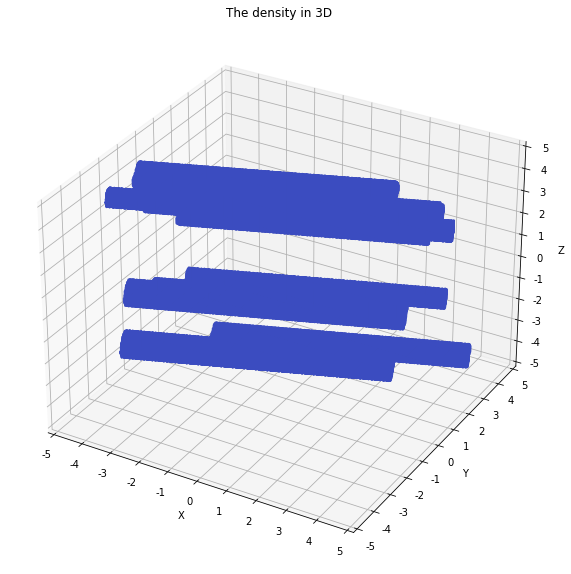

In [18]:
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

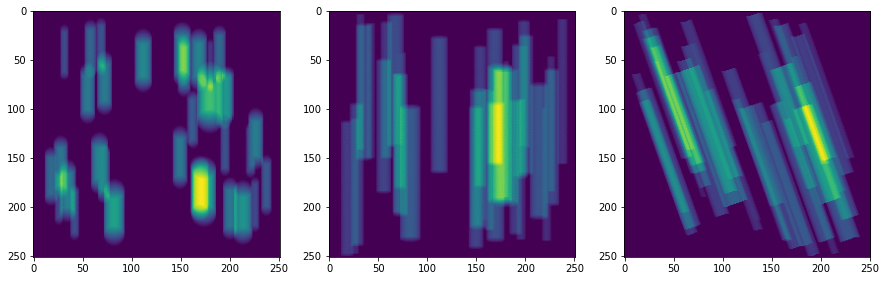

In [14]:
#plot_slices(simulation.density, simulation.grid, direction ='z')
plt_slices_sum(simulation)

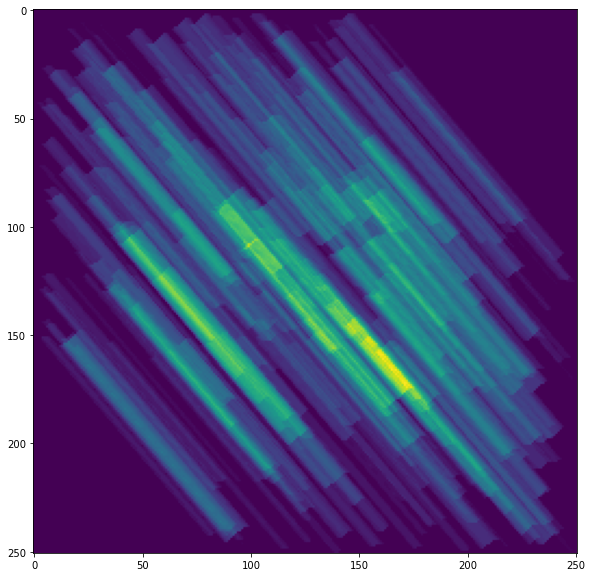

In [3]:
plt.figure(figsize = (10,10))
plt.imshow(simulation.density.sum(axis=2))
#plt.imshow(simulation.density[:,80,:])

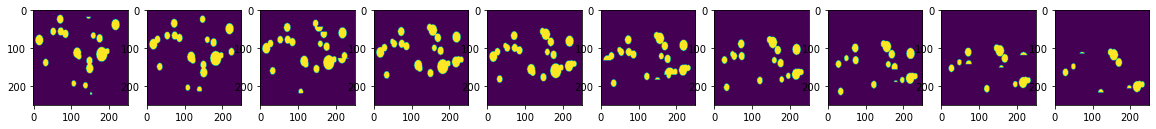

In [3]:
plot_slices_at_interval(12, 100, simulation, 'x')

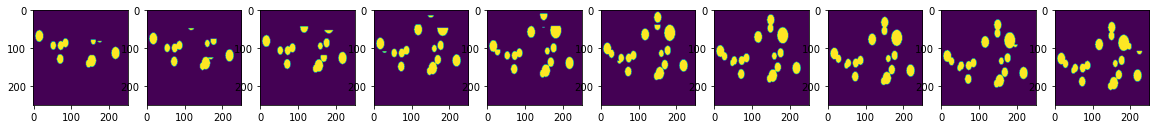

In [5]:
plot_slices_at_interval(6, 50, simulation, 'y')

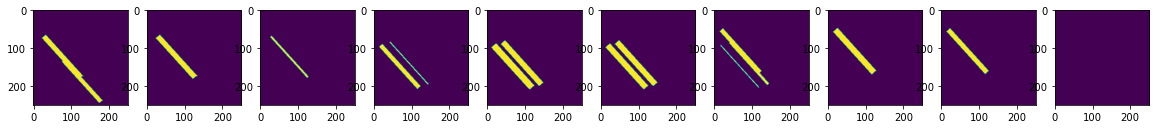

In [4]:
plot_slices_at_interval(5, 50, simulation, 'z')

In [15]:
simulation.pin_memory()

the maximal difference between the implementation of the FTI is 0.0028350073017888657


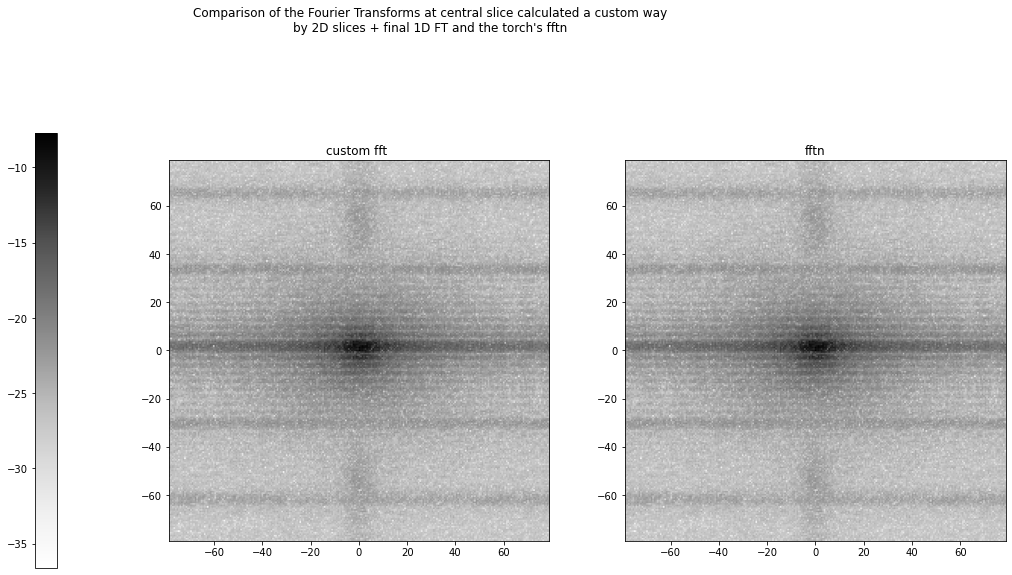

In [16]:
simulation.calculate_custom_FTI_3D_slice(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')

plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

FI_slice_custom


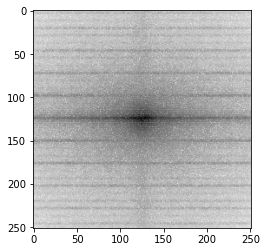

In [8]:
plt.imshow(np.log(simulation.FTI_sinc), cmap = 'Greys')

In [31]:
def plt_slices_sim(simulation):
    fig,axs = plt.subplots(1,3,figsize = (15,5))
    ax = axs[0]
    im = ax.imshow(np.log(simulation.FTI_custom[120,:,:]), cmap = 'Greys')
    ax = axs[1]
    im = ax.imshow(np.log(simulation.FTI_custom[:,120,:]), cmap = 'Greys')
    ax = axs[2]
    im = ax.imshow(np.log(simulation.FTI_custom[:,:,120]), cmap = 'Greys')
    plt.show()    


In [ ]:
#simulation.calculate_custom_FTI_3D(device = 'cpu')
#plt_slices_sim(simulation)

In [24]:
a = simulation.Q[126,:,:].flatten()

In [25]:
a

tensor([111.5181, 111.0730, 110.6296,  ..., 110.6296, 111.0730, 111.5181])

torch.Size([49049]) (49049,)


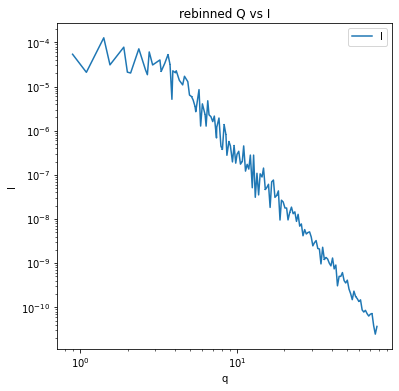

In [17]:
simulation.reBin(200, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

In [18]:
simulation.save_data(directory='dat_files')
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.rMean, h = simulation.hMean))

the cylinder file with radius 0.313 and height 5.813 is saved


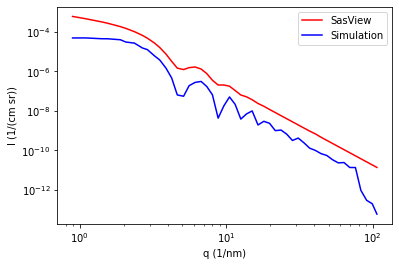

In [34]:
simulation.init_sas_model()
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

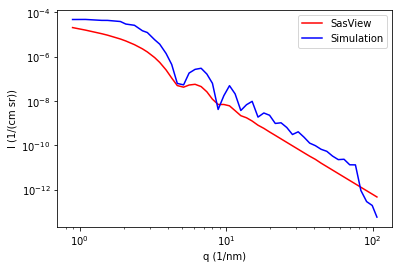

In [36]:

simulation.update_scaling(3.5198e-02)
plot_simulation_vs_sas( simulation.binned_slice, simulation.qx_sas, simulation.I_sas)

In [57]:
simulation.FTI_slice_custom

array([[3.96566185e-13, 1.44214659e-12, 1.62271000e-11, ...,
        2.48166528e-11, 6.89554731e-12, 8.57248547e-12],
       [1.00941808e-11, 2.99186797e-11, 1.45020316e-10, ...,
        5.79957472e-12, 7.10766998e-13, 1.19187783e-11],
       [2.02335074e-12, 1.39506103e-11, 6.04360996e-11, ...,
        9.62420549e-13, 1.72349347e-12, 4.01842074e-13],
       ...,
       [6.77598797e-12, 4.64564400e-12, 4.44232281e-11, ...,
        6.16905746e-12, 3.25597271e-11, 2.11795926e-11],
       [1.72440705e-11, 1.35578671e-11, 6.79395817e-11, ...,
        1.05244033e-11, 4.87724800e-12, 2.12932291e-11],
       [8.73414250e-12, 1.28120050e-12, 2.86011879e-11, ...,
        5.07674278e-13, 3.07413164e-12, 7.31140805e-12]])

the maximal difference between the implementation of the FTI is 1.755914088992787


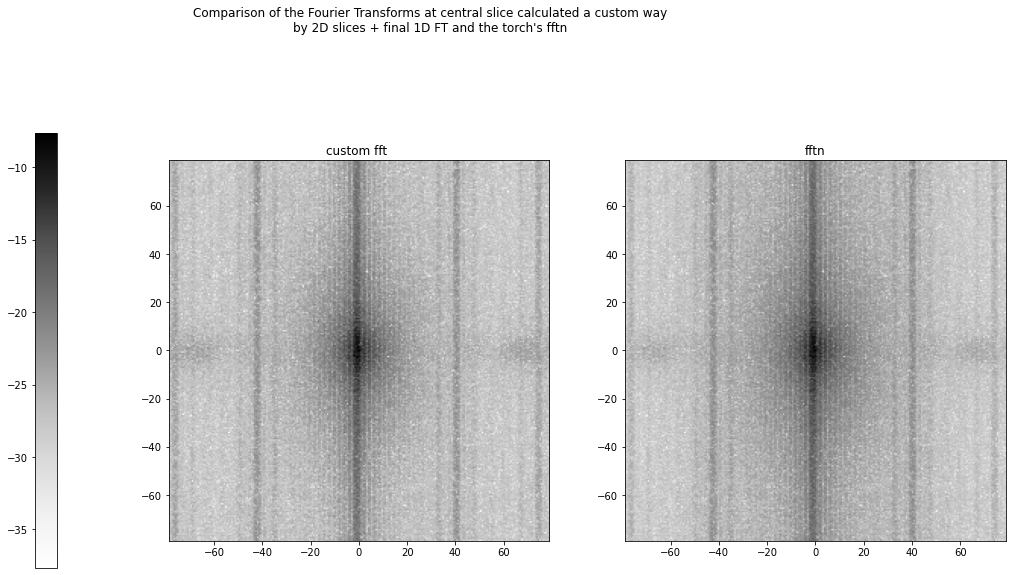

In [69]:
# the caption is wrong: it is actualy FTI of slice vs its sinc'ed
plot_FTI_version_center(simulation.FTI_slice_custom, simulation.FTI_sinc, simulation.qx)

In [26]:
import numpy as np

In [45]:
simulation.box_size/simulation.nPoints == simulation.grid_space

False

In [33]:
slice = simulation.Q[126,:,:]

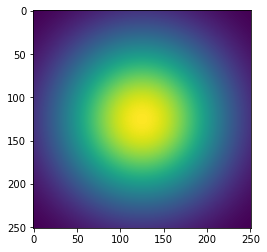

In [42]:
plt.imshow(np.sinc(slice*simulation.grid_space/2/np.pi)**4)

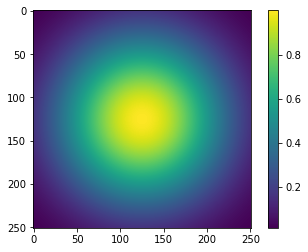

In [43]:
img = plt.imshow(np.sinc(slice*simulation.grid_space/2/np.pi)**4)
plt.colorbar(img)

In [28]:
simulation.Q.min()


tensor(2.0648e-06)

In [29]:
Q = np.linspace(0, 1, 1000)

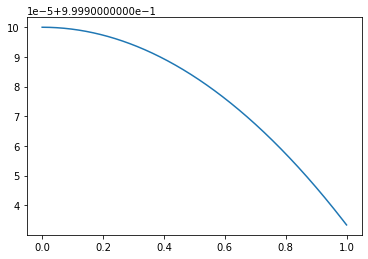

In [30]:
plt.plot(Q,np.sinc(Q*0.02/np.pi))

In [35]:
# modified from: https://stackoverflow.com/questions/47932955/how-to-check-if-a-3d-point-is-inside-a-cylinder
def points_in_cylinder(pt1, pt2, r, q):
    vec = pt2 - pt1
    const = r * np.linalg.norm(vec)
    return np.array(
        (np.dot(q - pt1, vec) >= 0) * 
        (np.dot(q - pt2, vec) <= 0) *
        (np.linalg.norm(np.cross(q - pt1, vec), axis=1) <= const),
        dtype=float
        )

In [38]:
x = np.linspace(-5,5,200)
y = np.linspace(-5,5,200)
z = np.linspace(-5,5,200)
arr = np.vstack(np.meshgrid(x, y, z)).reshape(3,-1).T
coords = np.array(np.meshgrid(x, y, z))
coordsArr = np.vstack(coords).reshape(3,-1).T
density = np.zeros(coords.shape[1:])
kansas=density.shape

In [39]:
lindensity2 = points_in_cylinder(pt1 = np.array([0, -3, -3]), pt2 = np.array([0, 3, 3]), r=1, q=coordsArr)
density2 = np.array(lindensity2).reshape(kansas)

In [41]:
h = 3
theta = 20
phi = 15

In [42]:
lindensity2 = points_in_cylinder(pt1 = np.array([0, -3, -3]), pt2 = np.array([0 + np.abs(np.abs(np.cos(np.deg2rad(theta))*h)*np.sin(np.deg2rad(phi))), -3 + np.abs(np.abs(np.cos(np.deg2rad(theta))*h)*np.cos(np.deg2rad(phi))) , -3+np.abs(np.sin(np.deg2rad(theta))*h)]), r=1, q=coordsArr)

In [43]:
density2 = np.array(lindensity2).reshape(kansas)

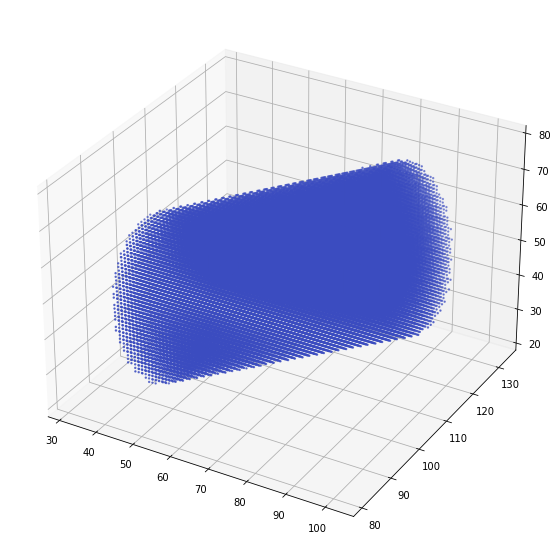

In [45]:

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ='3d')
values = density2.nonzero()
xx, yy, zz = values[0],values[1],values[2]
img = ax.scatter3D(xx, yy, zz, zdir='z', c= density2[xx,yy,zz],  cmap="coolwarm" , s = 2, marker = 'o')